# Module 3 - Lab 1 - LLM App Arch 
## Pre-requisites
- ollama installed and running 
    - handled by codespace custom initialization 

## Pull the LLM model

In [ ]:
# ollama - pull the model
!ollama pull llama3.2:1b-instruct-q4_0

In [1]:
# list out LLMs available
!ollama list  

NAME                ID              SIZE      MODIFIED    
llama3.2:1b         baf6a787fdff    1.3 GB    4 hours ago    
llama3.2:3b         a80c4f17acd5    2.0 GB    4 hours ago    
deepseek-r1:1.5b    a42b25d8c10a    1.1 GB    2 days ago     


## LLM to use

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="llama3.2:1b-instruct-q4_0",
    base_url="http://localhost:11434/v1", # Ollama
    #base_url="http://localhost:1234/v1", #LM Studio
    api_key="not-needed"
    )

# Build the Graph 
- Using LangGraph 
    - prebuilt `MessagesState`
        - contains simple `messages` key
            - list of `AnyMessage` objects
        - uses `add_messages` reducer 
    - `MemorySaver()` 
        - in-memory key-value store for Graph state


## Define State

In [5]:
# LangGraph `MessageState` 
# - contains a built-in `messages` key
# - added our custom key to store summaries
from langgraph.graph import MessagesState 

class State(MessagesState):
    summary: str

## Define Nodes

In [6]:
# Define node to invoke LLM 
# - incorporate summmary if exists

from langchain_core.messages import SystemMessage

def invoke_llm(state: State):
    summary = state.get("summary", "")
    if summary:
        sys_msg = f"Summary of conversation: {summary}"
        messages = [SystemMessage(content=sys_msg)] + state["messages"]
    else:
        messages = state["messages"]
    response = llm.invoke(messages)
    return { "messages": response }

In [ ]:
# Define node to summarize conversations
# - reduce cost by reducing number of tokens
#   - trade off is some details of conversation might be lost

from langchain_core.messages import HumanMessage, RemoveMessage

def summarize_thread(state: State):
    summary = state.get("summary", "")

    if summary:
        summary_prompt_msg = (
            f"SUMMARY: {summary}\n" 
            "Create a a summary of the conversation above:"
        )
    else:
        summary_prompt_msg = "Create a summary of the conversation above:"
    # add summary prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_prompt_msg)]
    response = llm.invoke(messages)
    # delete all but the 2 most recent messages
    post_deleted_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {
        "summary": response.content,
        "messages": post_deleted_messages
    }

## Define Edge Condition

In [8]:
# Condition edge to check if we need to produce summary
from langgraph.graph import END

def require_summary(state: State):
    messages = state["messages"]
    if len(messages) > 6:
        return "summarize_thread"
    else:
        return END

# Create the Graph

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


# Build graph
builder = StateGraph(State)
builder.add_node("assistant", invoke_llm)
builder.add_node("summarize_thread", summarize_thread)

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", require_summary)
builder.add_edge("summarize_thread", END)


memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

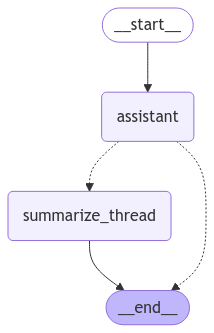

In [10]:
# Display graph
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# Create unique thread id for short-term memory (checkpointer)
import uuid
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

In [12]:
from langchain_core.messages import HumanMessage
msgList = [
    HumanMessage(content="My name is Joshua"),
    HumanMessage(content="I live in Phoenix"), 
    HumanMessage(content="I have 2 dogs"),
    HumanMessage(content="I worked in restaurant"),
    HumanMessage(content="Loved going on hikes"),
    HumanMessage(content="Can you recommend good hikes near my area"),
    HumanMessage(content="Can you recommend good restaurants near my area")
]               

for msg in msgList:
    output = graph.invoke({"messages": [msg]}, config)
    for m in output['messages'][-2:]:
        m.pretty_print()



================================ Human Message =================================

My name is Joshua
================================== Ai Message ==================================

Hello Joshua, what can I help you with today?
================================ Human Message =================================

I live in Phoenix
================================== Ai Message ==================================

Phoenix is a great city. What's on your mind, Joshua? Would you like to talk about something specific or just shoot the breeze for a bit?
================================ Human Message =================================

I have 2 dogs
================================== Ai Message ==================================

Having two dogs must be a rewarding experience. Phoenix has plenty of dog-friendly spots and activities, such as hiking trails, parks, and even some outdoor cafes where your furry friends can join you.

Do you have any pets besides your own, or are they already part of the 

In [13]:
graph.get_state(config).values.get("summary","")


'Here is a summary of our conversation:\n\nWe discussed your personal life, specifically that you worked in a restaurant and have 2 dogs in Phoenix. I shared some details about your job in restaurants, but we only covered about that topic further in this conversation.'

In [14]:
graph.get_state(config).values.get("messages","")

[HumanMessage(content='Can you recommend good restaurants near my area', additional_kwargs={}, response_metadata={}, id='a7b000b6-02f6-411a-97e5-b5be9b7b7295'),
 AIMessage(content="I'd be happy to provide you with some recommendations for good restaurants in the Phoenix area.\n\nAs a restaurant worker, I'm sure you've had a chance to try out many different types of cuisine. If you're looking for Recommendations, here are a few:\n\n* Pizzeria Bianco: A popular spot for wood-fired pizza and craft cocktails\n* La Taqueria: A casual Mexican restaurant with creative tacos and burritos\n* Barrio Cafe: A fun spot for brunch or dinner with a focus on local ingredients\n\nIf you're looking for something unique, you might want to try:\n\n* Sonoran Hot Air Balloon Ranch Restaurant & Spa: A rustic eatery serving up classic American fare with a twist\n* MacAlpine's Diner: A retro-style diner with burgers, sandwiches, and milkshakes\n\nPhoenix has a diverse food scene, so I encourage you to explore 